----
----
# <b> DLMI Challenge </b>
# <b> Improved ResNet50 MIL training </b>
# <b> Matteo MARENGO | matteo.marengo@ens-paris-saclay.fr </b>
# <b> Manal MEFTAH | manal.meftah@ens-paris-saclay.fr </b>

----
----
# <b> Import libraries </b>

In [1]:
import os
import random
from datetime import date

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import balanced_accuracy_score
from torch.utils.data.dataloader import default_collate

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

set_seed(42)


----
----
# <b> Load the model </b>

In [ ]:
class PatientImagesDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.csv_file = csv_file  
        self.transform = transform
        self.patient_images = {}  
        self.patients_info = {}
        self.df = pd.read_csv(csv_file)
        self.df = self.csv_processing(self.df)
        self.load_images()
  

    def csv_processing(self, features):
        def calculate_age(born):
            today = date.today()
            try:
                [day, month, year] = [int(i) for i in born.split("/")]
            except:
                [day, month, year] = [int(i) for i in born.split("-")]
            return today.year - year - ((today.month, today.day) < (month, day))

        features["DOB"] = features["DOB"].apply(calculate_age)  
        features["GENDER"] = features["GENDER"].apply(lambda s: 0 if s == 'M' else 1)
        return features


    def load_images(self):
        for _, row in self.df.iterrows():
            patient_id = row['ID']
            patient_folder = os.path.join(self.root_dir, patient_id)
            self.patient_images[patient_id] = []  
            if os.path.isdir(patient_folder):
                for img_filename in os.listdir(patient_folder):
                    img_path = os.path.join(patient_folder, img_filename)
                    self.patient_images[patient_id].append(img_path)
                    self.patients_info[img_path] = row.to_dict()

    def __len__(self):
        return len(self.df)  
    
    def __getitem__(self, idx):
        patient_id = self.df.iloc[idx]['ID']
        patient_data = self.df.iloc[idx].to_dict()
        images = [Image.open(img_path).convert('RGB') for img_path in self.patient_images[patient_id]]
        if self.transform:
            images = [self.transform(image) for image in images]
        label = patient_data['LABEL']
        patient_info = {key: patient_data[key] for key in patient_data if key not in ['ID', 'LABEL']}
        return images, label, patient_info
transform = transforms.Compose([
    transforms.Resize((156, 156)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
def custom_train_val_split(dataset, train_frac=0.8):
    patient_ids = list(dataset.patient_images.keys())
    total_patients = len(patient_ids)
    
    train_patient_ids = set(np.random.choice(patient_ids, int(train_frac * total_patients), replace=False))
    val_patient_ids = set(patient_ids) - train_patient_ids
    
    train_df = dataset.df[dataset.df['ID'].isin(train_patient_ids)].reset_index(drop=True)
    val_df = dataset.df[dataset.df['ID'].isin(val_patient_ids)].reset_index(drop=True)

    train_dataset = PatientImagesDataset(dataset.root_dir, dataset.csv_file, dataset.transform)
    train_dataset.df = train_df
    train_dataset.load_images()  

    val_dataset = PatientImagesDataset(dataset.root_dir, dataset.csv_file, dataset.transform)
    val_dataset.df = val_df
    val_dataset.load_images()  
    return train_dataset, val_dataset

def custom_collate_fn(batch):
    images_flattened = [image for batch_item in batch for image in batch_item[0]]
    labels = torch.tensor([item[1] for item in batch])
    patient_infos = [item[2] for item in batch]
    
    images_collated = default_collate(images_flattened)
        
    return images_collated, labels, patient_infos


In [11]:

class MultiInstanceModel(nn.Module):
    def __init__(self, num_patient_features, output_dim=2):
        super(MultiInstanceModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  
        
        self.patient_info_layer = nn.Linear(num_patient_features, 128)
        
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs + 128, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )
        
    def forward(self, images, patient_info):
        img_features = torch.stack([self.resnet(img.unsqueeze(0)) for img in images]).mean(0)
        
        patient_info_features = self.patient_info_layer(patient_info)
        
        combined_features = torch.cat((img_features, patient_info_features), dim=1)
        output = self.classifier(combined_features)
        return output



----
----
# <b> Do the training </b>

In [12]:

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path):
    training_losses = []
    validation_losses = []
    validation_balanced_accuracies = []
    
    best_val_balanced_acc = 0.0  

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        all_train_preds = []
        all_train_labels = []

        for images, labels, patient_infos in train_loader:
            images = [img.to(device) for img in images]
            patient_infos_tensor = torch.stack([torch.tensor(list(info.values()), dtype=torch.float) for info in patient_infos]).to(device)
            labels = labels.to(device).float().unsqueeze(1)  
            optimizer.zero_grad()
            outputs = model(images, patient_infos_tensor)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            preds = torch.sigmoid(outputs).detach().round().cpu().numpy()
            all_train_preds.extend(preds)
            all_train_labels.extend(labels.cpu().numpy())

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        all_val_preds = []
        all_val_labels = []
        with torch.no_grad():
            for images, labels, patient_infos in val_loader:
                images = [img.to(device) for img in images]
                patient_infos_tensor = torch.stack([torch.tensor(list(info.values()), dtype=torch.float) for info in patient_infos]).to(device)
                labels = labels.to(device).float().unsqueeze(1)  

                outputs = model(images, patient_infos_tensor)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()

                preds = torch.sigmoid(outputs).detach().round().cpu().numpy()
                all_val_preds.extend(preds)
                all_val_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        validation_losses.append(avg_val_loss)

        val_balanced_acc = balanced_accuracy_score(all_val_labels, np.array(all_val_preds).flatten())
        validation_balanced_accuracies.append(val_balanced_acc)

        if val_balanced_acc > best_val_balanced_acc:
            print(f'New best validation balanced accuracy: {val_balanced_acc:.4f} (previous: {best_val_balanced_acc:.4f}), saving model...')
            best_val_balanced_acc = val_balanced_acc
            
            # Save the model state
            torch.save(model.state_dict(), save_path)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Balanced Acc: {val_balanced_acc:.4f}')

    return training_losses, validation_losses, validation_balanced_accuracies


In [13]:

csv_file = '/kaggle/input/dlmi-competition/trainset/trainset_true.csv'
root_dir = '/kaggle/input/dlmi-competition/trainset'

train_dataset = PatientImagesDataset(root_dir=root_dir, csv_file=csv_file, transform=transform)


train_dataset, val_dataset = custom_train_val_split(train_dataset, train_frac=0.75)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



num_patient_features = 3  
model = MultiInstanceModel(num_patient_features=num_patient_features, output_dim=2).to(device)
model = model.to(device)  
criterion = torch.nn.BCEWithLogitsLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)



num_epochs = 30  


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s]


In [15]:

save_path = '/kaggle/working/best_model_resnet50.pth'  
training_losses, validation_losses, validation_balanced_accuracies = train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path
)


New best validation balanced accuracy: 0.6243 (previous: 0.0000), saving model...
Epoch [1/30], Training Loss: 23.4589, Validation Loss: 6.6383, Validation Balanced Acc: 0.6243
Epoch [2/30], Training Loss: 22.0177, Validation Loss: 4.0912, Validation Balanced Acc: 0.5000
Epoch [3/30], Training Loss: 13.1410, Validation Loss: 28.1503, Validation Balanced Acc: 0.5000
Epoch [4/30], Training Loss: 18.9388, Validation Loss: 34.3386, Validation Balanced Acc: 0.5000
New best validation balanced accuracy: 0.6865 (previous: 0.6243), saving model...
Epoch [5/30], Training Loss: 17.6241, Validation Loss: 10.3123, Validation Balanced Acc: 0.6865
New best validation balanced accuracy: 0.7143 (previous: 0.6865), saving model...
Epoch [6/30], Training Loss: 4.5826, Validation Loss: 1.8372, Validation Balanced Acc: 0.7143
Epoch [7/30], Training Loss: 2.0110, Validation Loss: 3.0938, Validation Balanced Acc: 0.6429
New best validation balanced accuracy: 0.8915 (previous: 0.7143), saving model...
Epoch 

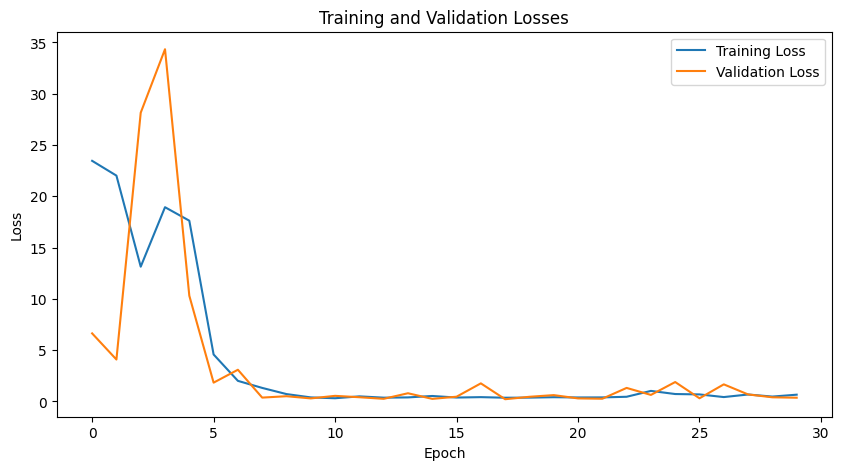

In [16]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()



----
----
# <b> Do the testing </b>

In [ ]:
class TestPatientImagesDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.csv_file = csv_file
        self.transform = transform
        self.patient_images = {}
        self.patients_info = {}
        self.df = pd.read_csv(csv_file)
        self.df = self.csv_processing(self.df)
        self.load_images()

    def csv_processing(self, features):
        if 'LABEL' in features.columns:
            features = features.drop(columns=['LABEL'])

        def calculate_age(born):
            today = date.today()
            try:
                [day, month, year] = [int(i) for i in born.split("/")]
            except:
                [day, month, year] = [int(i) for i in born.split("-")]
            return today.year - year - ((today.month, today.day) < (month, day))

        features["DOB"] = features["DOB"].apply(calculate_age)  
        features["GENDER"] = features["GENDER"].apply(lambda s: 0 if s == 'M' else 1)
        return features


    def load_images(self):
        for _, row in self.df.iterrows():
            patient_id = row['ID']
            patient_folder = os.path.join(self.root_dir, patient_id)
            self.patient_images[patient_id] = []  
            if os.path.isdir(patient_folder):
                for img_filename in os.listdir(patient_folder):
                    img_path = os.path.join(patient_folder, img_filename)
                    self.patient_images[patient_id].append(img_path)
                    self.patients_info[img_path] = row.to_dict()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        patient_id = self.df.iloc[idx]['ID']
        patient_data = self.df.iloc[idx].to_dict()
        images = [Image.open(img_path).convert('RGB') for img_path in self.patient_images[patient_id]]
        if self.transform:
            images = [self.transform(image) for image in images]
        patient_info = {key: patient_data[key] for key in patient_data if key not in ['ID']}
        return images, patient_info, patient_id

In [ ]:
test_dataset = TestPatientImagesDataset(
    root_dir='/kaggle/input/dlmi-competition/testset', 
    csv_file='/kaggle/input/dlmi-competition/testset/testset_data.csv', 
    transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn)

In [ ]:
# Load the saved model weights if not trained in the current session
#model_path = ''
#model.load_state_dict(torch.load(model_path, map_location=device))

# Set the model to evaluation mode
model.eval()


In [ ]:
predictions = []

with torch.no_grad():
    for images, patient_infos, patient_ids in test_loader:
        images = images.to(device)
        
    
        if isinstance(patient_infos, dict):  
            patient_infos = [patient_infos]  
        patient_infos_tensor = torch.tensor([list(info.values()) for info in patient_infos], dtype=torch.float).to(device)
        
        assert patient_infos_tensor.shape[1] == 3, "Incorrect number of patient features"

        output = model(images, patient_infos_tensor)

        pred = torch.sigmoid(output).mean().item() > 0.5 
        patient_id = patient_ids[0] if isinstance(patient_ids, (list, torch.Tensor)) else patient_ids
        predictions.append([patient_id, int(pred)])


submission_df= pd.DataFrame(predictions, columns=['Id', 'Predicted'])


In [ ]:
# Convert predictions to DataFrame and save to CSV for submission
submission_df = pd.DataFrame(predictions, columns=['Id', 'Predicted'])
submission_df.to_csv('/kaggle/working/submission.csv', index=False)
